# Empirical analysis of the 5G coverage 

#### Imports

In [290]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scikit_posthocs as sp
import seaborn as sns
from scipy.stats import kstest, spearmanr

#### Dataset

In [291]:
df_4g = pd.read_csv('datasets/4G-Passive-Measurements.csv')

In [292]:
print(df_4g.columns)
df = df_4g[['RSRP', 'Speed', 'distance', 'Latitude', 'Longitude', 'scenario', 'MNC', 'campaign', 'Time']]
df = df[(df['RSRP'] >= -144) & (df['RSRP'] <= -44)]  # remove impossible values 
df = df[(df['scenario'] == 'OD') | (df['scenario'] == 'IS')]
df = df.replace('"Op"[1]', 'Op1')
df = df.replace('"Op"[2]', 'Op2')
df = df.loc[df.groupby(['Latitude', 'Longitude', 'Time', 'MNC', 'scenario'])['RSRP'].idxmax()]  # filter for only the strongest RSRP on the same loc and time
print(df.head())

Index(['Unnamed: 0', 'Date', 'Time', 'UTC', 'Latitude', 'Longitude',
       'Altitude', 'Speed', 'EARFCN', 'Frequency', 'PCI', 'MNC',
       'CellIdentity', 'eNodeB.ID', 'Power', 'SINR', 'RSRP', 'RSRQ',
       'scenario', 'cellLongitude', 'cellLatitude', 'cellPosErrorLambda1',
       'cellPosErrorLambda2', 'n_CellIdentities', 'distance', 'Band',
       'campaign'],
      dtype='object')
         RSRP  Speed    distance   Latitude  Longitude scenario  MNC  \
114007 -81.30   6.23  318.901604  41.823736  12.467485       OD  Op1   
114008 -88.73   6.23  359.606897  41.823736  12.467485       OD  Op2   
114010 -92.44   6.23  744.839087  41.823736  12.467485       OD  Op1   
114015 -92.61   6.62  361.630533  41.823736  12.467527       OD  Op2   
114019 -92.00   6.62  361.630533  41.823736  12.467527       OD  Op2   

                           campaign          Time  
114007  campaign_28_OD_4G_speedtest  18:23:11.604  
114008  campaign_28_OD_4G_speedtest  18:23:12.159  
114010  campaign_28_O

In [293]:
op1_is = df[(df['scenario'] == 'IS') & (df['MNC'] == "Op1")]
op1_od = df[(df['scenario'] == 'OD') & (df['MNC'] == "Op1")]
op2_is = df[(df['scenario'] == 'IS') & (df['MNC'] == "Op2")]
op2_od = df[(df['scenario'] == 'OD') & (df['MNC'] == "Op2")]

print(op1_od.head())
print(op1_is.shape, op1_od.shape, op2_is.shape, op2_od.shape)

          RSRP  Speed    distance   Latitude  Longitude scenario  MNC  \
114007  -81.30   6.23  318.901604  41.823736  12.467485       OD  Op1   
114010  -92.44   6.23  744.839087  41.823736  12.467485       OD  Op1   
64664  -104.97   2.92  744.059939  41.823743  12.467466       OD  Op1   
64666   -79.57   2.92  317.165543  41.823743  12.467466       OD  Op1   
64667   -90.19   0.04  744.059518  41.823743  12.467473       OD  Op1   

                           campaign          Time  
114007  campaign_28_OD_4G_speedtest  18:23:11.604  
114010  campaign_28_OD_4G_speedtest  18:23:12.510  
64664      campaign_12_OD_4G_gaming  17:27:31.109  
64666      campaign_12_OD_4G_gaming  17:27:32.071  
64667      campaign_12_OD_4G_gaming  17:27:32.367  
(34797, 9) (15802, 9) (35936, 9) (16913, 9)


### Create violin plots to inspect distributions

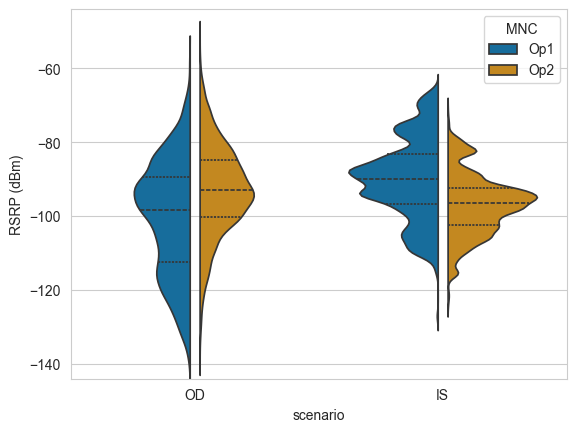

In [294]:
sns.violinplot(x='scenario', y='RSRP', hue='MNC', data=df, split=True, gap=0.1, inner='quart', palette='colorblind')
## lines show the quartiles of the data
sns.set_style('whitegrid')
plt.ylabel('RSRP (dBm)')
plt.ylim(-144, -44)
plt.show()

In [295]:
df_4g = df_4g[(df_4g['RSRP'] >= -144) & (df_4g['RSRP'] <= -44) &
              (df_4g['RSRQ'] >= -19.5) & (df_4g['RSRQ'] <= -3) &
              (df_4g['SINR'] >= -20) & (df_4g['SINR'] <= 20)]
df_4g = df_4g.fillna(0)

### Statistical analysis

In [296]:
# test for normal distribution
_, p_op1_is = kstest(op1_is['RSRP'], 'norm')
_, p_op1_od = kstest(op1_od['RSRP'], 'norm')
_, p_op2_is = kstest(op2_is['RSRP'], 'norm')
_, p_op2_od = kstest(op2_od['RSRP'], 'norm')

print(f'Statistical results for testing for normal distribution are:\n'
      f'Operator 1, IS: {p_op1_is:.3f}\n'
      f'Operator 1, OD: {p_op1_od:.3f}\n'
      f'Operator 2, IS: {p_op2_is:.3f}\n'
      f'Operator 2, OD: {p_op2_od:.3f}')

Statistical results for testing for normal distribution are:
Operator 1, IS: 0.000
Operator 1, OD: 0.000
Operator 2, IS: 0.000
Operator 2, OD: 0.000


All test show p-values < 0.001, rejecting the null-hypothesis of a normal distribution.
Therefore, for futher statistical testing, non-parametric tests need to be used.

In [297]:
n_test = 4  # bonferroni correction on multiple comparisons
data = [op1_is['RSRP'], 
        op1_od['RSRP']]
p_op1_isvod = sp.posthoc_dunn(data) * n_test

data = [op2_is['RSRP'],
        op2_od['RSRP']]
p_op2_isvod = sp.posthoc_dunn(data) * n_test

data = [op1_is['RSRP'], 
        op2_is['RSRP']]
p_is_1v2 = sp.posthoc_dunn(data) * n_test

data = [op1_od['RSRP'],
        op2_od['RSRP']]
p_od_1v2 = sp.posthoc_dunn(data) * n_test


print(f"Statistical test results from Dunn's test while using a Bonferroni correction based on {n_test} tests:\n"
      f"Operator 1, IS vs. OD: {p_op1_isvod.iloc[0, 1]:.3f}\n"
      f"Operator 2, IS vs. OD: {p_op2_isvod.iloc[0, 1]:.3f}\n"
      f"Operator 1 vs. Operator 2, IS: {p_is_1v2.iloc[0, 1]:.3f}\n"
      f"Operator 1 vs. Operator 2, OD: {p_od_1v2.iloc[0, 1]:.3f}")

Statistical test results from Dunn's test while using a Bonferroni correction based on 4 tests:
Operator 1, IS vs. OD: 0.000
Operator 2, IS vs. OD: 0.000
Operator 1 vs. Operator 2, IS: 0.000
Operator 1 vs. Operator 2, OD: 0.000


All tests show p-values < 0.001, rejecting the null-hypothesis that the samples come from the same distribution.

### Correlation tests
Check for correlation between speed, distance, and location, and RSRP value while driving.
Should we look for correlations in the entire dataset or for each subset (Operator and scenario)?

<Axes: xlabel='RSRP', ylabel='Count'>

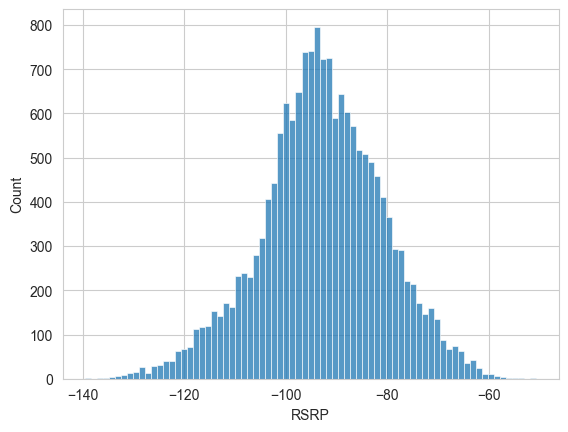

In [298]:
# sns.scatterplot(x=op1_od['Speed'], y=op1_od['RSRP'])
# sns.scatterplot(x=op1_od['distance'], y=op1_od['RSRP'])
# sns.scatterplot(x=op1_od['Latitude'], y=op1_od['RSRP'])
# sns.scatterplot(x=op1_od['Longitude'], y=op1_od['RSRP'])
sns.histplot(op2_od['RSRP'])

In [299]:
res_op1_speed = spearmanr(op1_od['RSRP'], op1_od['Speed'])
res_op2_speed = spearmanr(op2_od['RSRP'], op2_od['Speed'])
print(f'Results of Spearman correlation tests for RSRP and Speed:\n'
      f'Operator 1: {res_op1_speed.statistic:.3f}, {res_op1_speed.pvalue:.3f}\n'
      f'Operator 2: {res_op2_speed.statistic:.3f}, {res_op2_speed.pvalue:.3f}')

Results of Spearman correlation tests for RSRP and Speed:
Operator 1: -0.102, 0.000
Operator 2: -0.109, 0.000


In [300]:
res_dis_op1_is = spearmanr(op1_is['RSRP'], op1_is['distance'])
res_dis_op1_od = spearmanr(op1_od['RSRP'], op1_od['distance'])
res_dis_op2_is = spearmanr(op2_is['RSRP'], op2_is['distance'])
res_dis_op2_od = spearmanr(op2_od['RSRP'], op2_od['distance'])

print(f'Results of Spearman correlation tests for RSRP and distance:\n'
      f'Operator 1, IS: {res_dis_op1_is.statistic:.3f}, {res_dis_op1_is.pvalue:.3f}\n'
      f'Operator 1, OD: {res_dis_op1_od.statistic:.3f}, {res_dis_op1_od.pvalue:.3f}\n'
      f'Operator 2, IS: {res_dis_op2_is.statistic:.3f}, {res_dis_op2_is.pvalue:.3f}\n'
      f'Operator 2, OD: {res_dis_op2_od.statistic:.3f}, {res_dis_op2_od.pvalue:.3f}\n')

Results of Spearman correlation tests for RSRP and distance:
Operator 1, IS: -0.188, 0.000
Operator 1, OD: -0.574, 0.000
Operator 2, IS: 0.076, 0.000
Operator 2, OD: -0.350, 0.000



           Speed  Distance
Op1_IS       NaN -0.188115
Op1_OD -0.102426 -0.574253
Op2_IS       NaN  0.076428
Op2_OD -0.108638 -0.350363


[Text(0, 0.5, 'Op1_IS'),
 Text(0, 1.5, 'Op1_OD'),
 Text(0, 2.5, 'Op2_IS'),
 Text(0, 3.5, 'Op2_OD')]

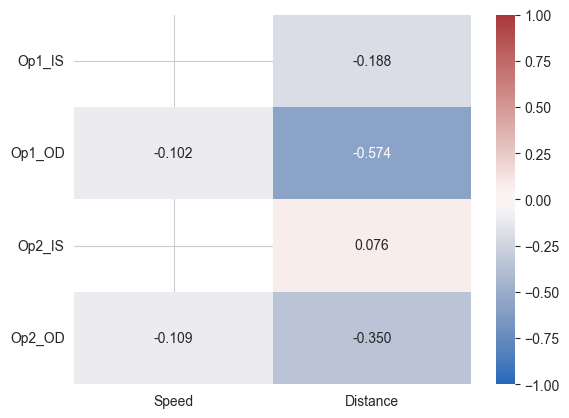

In [301]:
groups = ['Op1_IS', 'Op1_OD', 'Op2_IS', 'Op2_OD']
data = {'Speed': [np.nan, res_op1_speed.statistic, np.nan, res_op2_speed.statistic],
        'Distance': [res_dis_op1_is.statistic, res_dis_op1_od.statistic, res_dis_op2_is.statistic, res_dis_op2_od.statistic]}
correlations = pd.DataFrame(data, index=groups)
print(correlations)
ax = sns.heatmap(correlations, vmin=-1, vmax=1, annot=True, fmt=".3f", cmap='vlag')
ax.set_yticklabels(labels=groups, rotation=0)


### What can we do in the assignment?

* Could it be an idea to look at the correlation between signal strength and number of PCIs connected to the unit (4g dataset)?
* Alternatively, look into the different kinds of RSRPs in the 5g dataset and do a kind of time analysis?
* Or something completely different? I don't really know what could be possible and is easy enough to do in 1,5 weeks lol

In [302]:
def Pearson_correlation(X,Y):
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr

print(f'Pearson correlation between RSRP and distance: ', Pearson_correlation(df['RSRP'], df['distance']))
print(f'Pearson correlation between RSRP and speed: ', Pearson_correlation(df['RSRP'], df['Speed']))


Pearson correlation between RSRP and distance:  -0.3025937242402288
Pearson correlation between RSRP and speed:  nan


<Axes: >

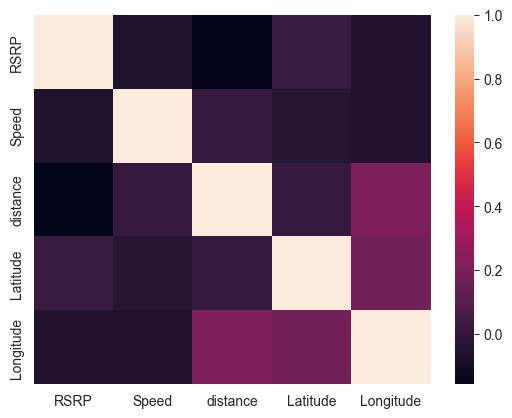

In [303]:
df_numeric_features_only = df.select_dtypes(include=np.number)
corr = df_numeric_features_only.corr(method = 'spearman')
sns.heatmap(corr)

In [304]:
long_drive = 'campaign_51_OD_4G'
trip_op1 = df[(df['campaign'] == long_drive) & (df['MNC'] == 'Op1')]
trip_op2 = df[(df['campaign'] == long_drive) & (df['MNC'] == 'Op2')]

fig = go.Figure()

scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

fig.add_trace(go.Scattermapbox(lat=trip_op1['Latitude'], lon=trip_op1['Longitude'],
    marker = dict(
        color = trip_op1['RSRP'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.8,
        size = 5.5,
        colorbar = dict(
            title={'text':"RSRP (dBm)"},
            titleside = "top",
            outlinecolor = "rgba(68, 68, 68, 0)",
        )
    )))
fig.update_layout(
    title=dict(
        text='Operator 1 | ' + long_drive,
        y=0.1,
        x=0.5,
        xanchor='center',
        yanchor='top'
    ),
    height=600,
    mapbox=dict(
        style='carto-positron',
        zoom=12.5,
        center=dict(lon=trip_op1['Longitude'].mean(), lat=trip_op1['Latitude'].mean())
    ),
    margin=dict(
        t=0,
        b=0,
        r=0,
        l=0
    )
)
fig.show()

In [305]:
fig = go.Figure()

scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

fig.add_trace(go.Scattermapbox(lat=trip_op2['Latitude'], lon=trip_op2['Longitude'],
    marker = dict(
        color = trip_op2['RSRP'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.8,
        size = 5.5,
        colorbar = dict(
            title={'text':"RSRP (dBm)"},
            titleside = "top",
            outlinecolor = "rgba(68, 68, 68, 0)",
        )
    )))
fig.update_layout(
    title=dict(
        text='Operator 2 | ' + long_drive,
        y=0.1,
        x=0.5,
        xanchor='center',
        yanchor='top'
    ),
    height=600,
    mapbox=dict(
        style='carto-positron',
        zoom=12.5,
        center=dict(lon=trip_op2['Longitude'].mean(), lat=trip_op2['Latitude'].mean())
    ),
    margin=dict(
        t=0,
        b=0,
        r=0,
        l=0
    )
)
fig.update_geos(
    visible=True
)
fig.show()

In [306]:
trip_op1['Time']

374541    15:58:54.533
374543    15:58:55.356
374525    15:58:52.097
374548    15:58:56.610
374415    15:58:28.534
              ...     
378572    16:24:48.629
378576    16:24:49.486
378583    16:24:50.380
378584    16:24:52.232
378587    16:24:53.404
Name: Time, Length: 712, dtype: object

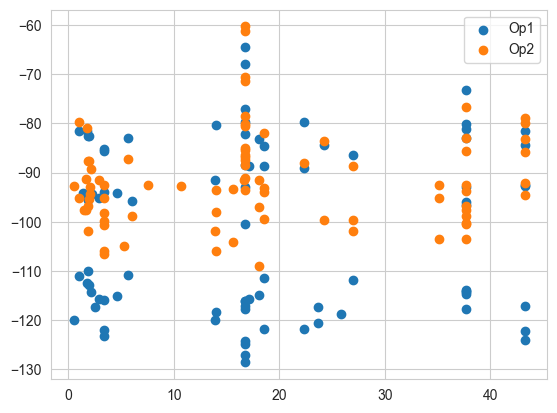

In [307]:
short_drive = 'campaign_52_OD_4G'
drive_op1 = df[(df['campaign'] == short_drive) & (df['MNC'] == 'Op1')]
drive_op2 = df[(df['campaign'] == short_drive) & (df['MNC'] == 'Op2')]

plt.scatter(drive_op1['Speed'], drive_op1['RSRP'])
plt.scatter(drive_op2['Speed'], drive_op2['RSRP'])
plt.legend(['Op1', 'Op2'])